In [1]:
%%capture

from dask.distributed import Client

# Remember! Please ensure you change the value below to the IP address and port of the cluster you have
# spun up; the below is an example so you are familiar with the format.

cluster_client = Client("tcp://10.0.0.44:8786")

In [2]:
import maystreet_data

# This function obtains price data broken into every minute for the below four ticker symbols.
# This function is distributed across the cluster by Dask automatically.
def get_daily_price_summary(requested_day):
    requested_year = 2022
    requested_month = '01'
    requested_ticker_symbols = ['IBM', 'AAPL', 'TSLA', 'V']

    mapped_ticker_symbols = ','.join([f"'{sym}'" for sym in requested_ticker_symbols])

    query = f"""
    WITH price_and_time AS (
    SELECT product, DATE_TRUNC('minute', TO_TIMESTAMP(ExchangeTimestamp / 1000000000)) as dp_minute, min(price) as min_price, max(price) as max_price, MIN(ReceiptTimestamp) min_receipt, MAX(ReceiptTimestamp) max_receipt
    FROM "prod_lake.p_mst_data_lake".mt_trade
    WHERE "year" = '{requested_year}' and "month" = '{requested_month}' and "day" = '{requested_day}' and "product" in ({mapped_ticker_symbols})
    GROUP BY DATE_TRUNC('minute', TO_TIMESTAMP(ExchangeTimestamp / 1000000000)), product
    )
    SELECT product,
            dp_minute,
            min_price,
            (SELECT min(Price) FROM "prod_lake.p_mst_data_lake".mt_trade WHERE "year" = '{requested_year}' and "month" = '{requested_month}' and "day" = '{requested_day}' and ReceiptTimestamp=min_receipt and product=price_and_time.product) open_price,
        (SELECT max(Price) FROM "prod_lake.p_mst_data_lake".mt_trade WHERE "year" = '{requested_year}' and "month" = '{requested_month}' and "day" = '{requested_day}' and ReceiptTimestamp=max_receipt and product=price_and_time.product) close_price,
        max_price
    FROM price_and_time
    order by product, dp_minute
    """

    return list(maystreet_data.query(maystreet_data.DataSource.DATA_LAKE, query))


In [3]:
import dask.bag as db

# Use Dask to distribute the above function across the compute nodes and aggregate the results back into the
# below variable.
days = db.from_sequence(['05', '06', '07'])
daily_summaries = days.map(get_daily_price_summary).compute()

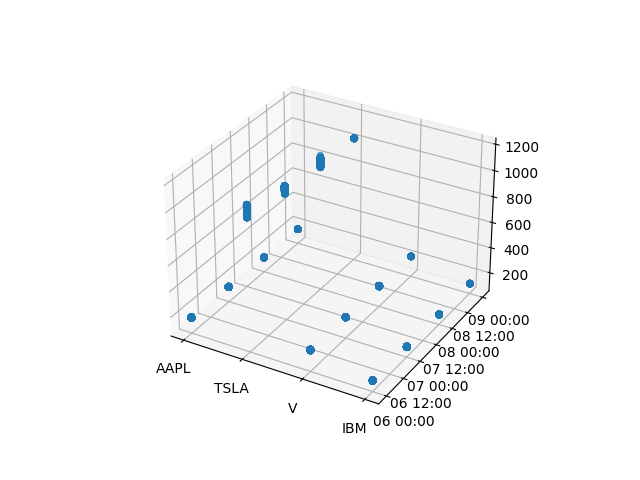

In [5]:
%matplotlib widget

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import itertools
import numpy as np
import datetime
import matplotlib.dates as mdates
sym_mapping = {'AAPL': 0, 'TSLA': 1, 'V': 2, 'IBM': 3}

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
all = list(itertools.chain(*daily_summaries))
x = np.array([sym_mapping[row['product']] for row in all])
y = np.array([datetime.datetime.fromtimestamp(row['dp_minute'] / 1000).toordinal() for row in all])
z = np.array([row['max_price'] for row in all])

ax.scatter(x, y, z)
ax.yaxis.set_major_formatter(mdates.DateFormatter('%d %H:%M'))

plt.xticks(range(0, 4), ['AAPL', 'TSLA', 'V', 'IBM'])
plt.show()
